In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_animal_dataset(dataset_path, image_size=(32, 32)):
    data = []
    labels = []
    label_map = {"cat": 0, "dog": 1, "panda": 2}

    for label_name in label_map:
        folder_path = os.path.join(dataset_path, label_name)
        for file_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file_name)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Unable to read {image_path}")
                    continue
                image = cv2.resize(image, image_size)
                data.append(image.flatten())
                labels.append(label_map[label_name])
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return np.array(data), np.array(labels)

In [4]:
# Load and split
X, y = load_animal_dataset(dataset_path="/content/drive/My Drive/CVPR/animals")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (240, 3072)
Train labels shape:  (240,)
Test data shape:  (60, 3072)
Test labels shape:  (60,)


In [6]:
X_train, X_test = X_train / 255.0, X_test / 255.0

## Build KNN

In [7]:
class KNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def compute_distances(self, X):
        train_squared = np.sum(np.square(self.X_train), axis=1)
        test_squared = np.sum(np.square(X), axis=1)[:, np.newaxis]
        cross_term = np.dot(X, self.X_train.T)
        dists_squared = test_squared + train_squared - 2 * cross_term
        dists = np.sqrt(np.maximum(dists_squared, 0))
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test, dtype=int)

        for i in range(num_test):
            nearest_idxs = np.argsort(dists[i])[:k]
            closest_y = np.array(self.y_train[nearest_idxs]).flatten().astype(int)
            counts = np.bincount(closest_y)
            y_pred[i] = np.argmax(counts)

        return y_pred

    def predict(self, X, k=1, num_loops=0):
            if num_loops == 0: dists = self.compute_distances(X)
            return self.predict_labels(dists, k=k)

## KNN Performace Evaluation

In [8]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

# compute distances
dists = classifier.compute_distances(X_test)

# predict labels
y_test_pred = classifier.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]

print(f'accuracy: {accuracy}')

accuracy: 0.4


## Cross Validation

In [11]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20]

# split data into 5 folds
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []

    for fold in range(num_folds):
        # validation set for this fold
        X_val = X_train_folds[fold]
        y_val = y_train_folds[fold]

        # training set = all other folds
        X_train_fold = np.concatenate([X_train_folds[i] for i in range(num_folds) if i != fold])
        y_train_fold = np.concatenate([y_train_folds[i] for i in range(num_folds) if i != fold])

        # train and evaluate
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)
        dists = classifier.compute_distances(X_val)
        y_val_pred = classifier.predict_labels(dists, k=k)

        acc = np.mean(y_val_pred == y_val)
        k_to_accuracies[k].append(acc)

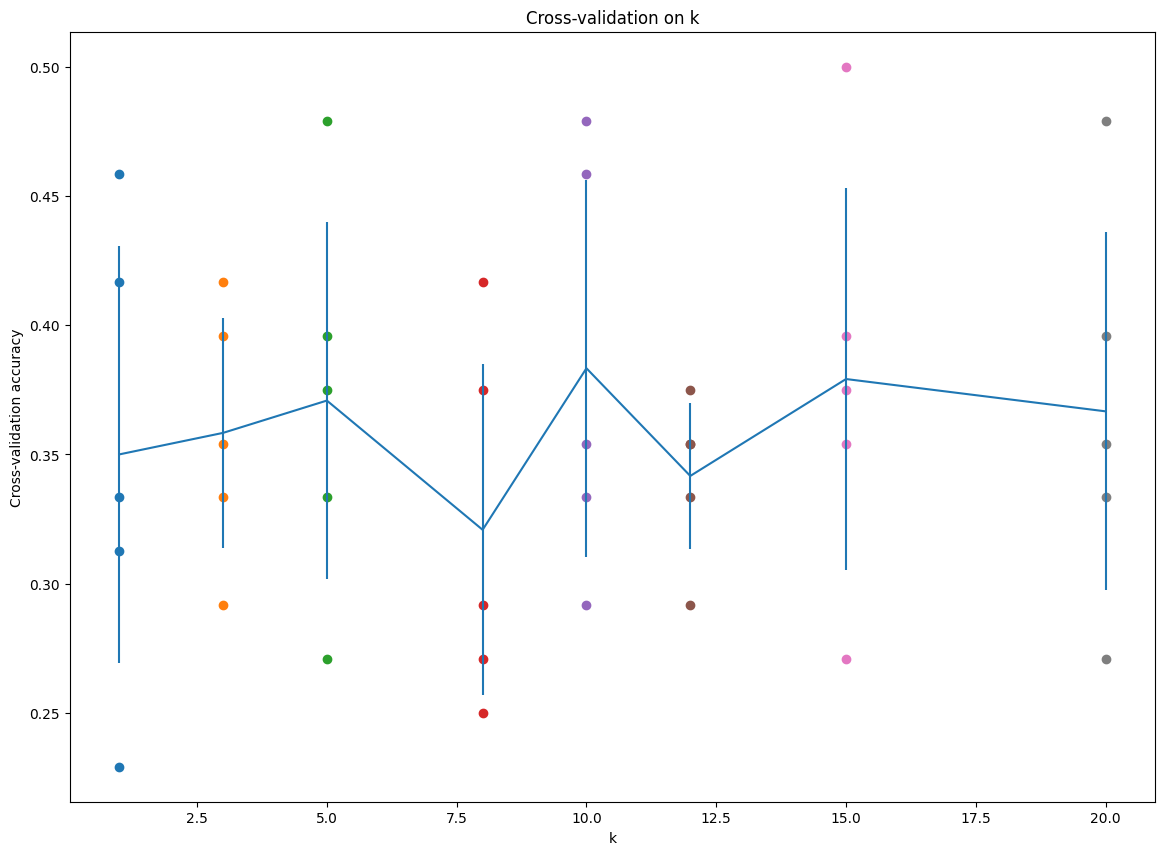

In [12]:
plt.figure(figsize=(14, 10))
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()